# SI 618 Homework 9

### Overview

The purpose of this homework is to give you more experience with data aggregation in Python, visualization using plotnine, a grammar of graphics implementation almost identical to ggplot in R,  and time-series analysis on a real-world dataset. You will be analyzing Wikipedia page popularity over an 18 month period from July 2015 to December 2016. The dataset is from (https://www.kaggle.com/c/web-traffic-time-series-forecasting/data), but we have provided the CSV (page_views.csv) for you. We have also provided an example document (si618_hw9_solution.html) of the intended solution.

## Question 0: Loading data and preprocessing (5 points)

Load the data (page_views.csv) and remove NA values. (There are many ways to handle missing data, we choose to remove rows for the purpose of this assignment.) 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from plotnine import stat_ecdf, ggplot, aes, geom_line, theme, ggtitle, scale_x_log10, scale_x_datetime, scale_y_continuous, xlab, ylab, xlim, ylim
from mizani.formatters import comma_format, date_format
from mizani.breaks import date_breaks
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
pages = pd.read_csv('page_views.csv')
pages = pages.dropna()
pages.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


## Question 1: Average Popularity Analysis (20 points)

#### Question 1-a: Plot the distribution of the average popularity of pages. (10 points)

Hint: You can use stat_ecdf of plotnine to plot a CDF (cumulative distribution function) 

Hint2: You can use the mizani package to format the labels in the figure with commas.

Your plot should look something like this. Note that there is one data point that will be removed while creating this plot. This will happen due to the use of logarithmic scale. You can handle that in different ways. Given that this only affects one row, in this case we chose to ignore it. You can plot this distribution in linear scale first to see why logairthmic scale is needed.

/Users/xuruge/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/Users/xuruge/opt/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_ecdf : Removed 1 rows containing non-finite values.


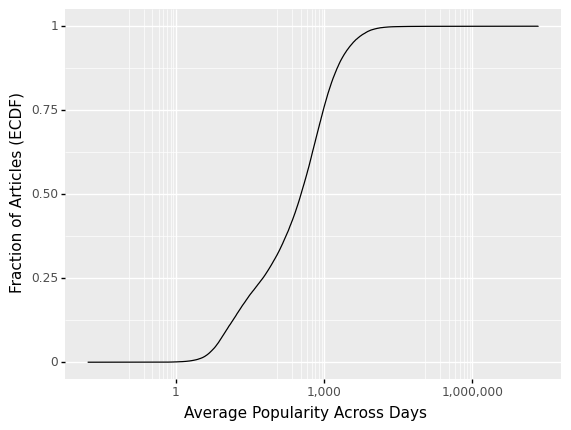

<ggplot: (8791445891798)>

In [3]:
popularity = pages.drop('Page', axis = 1)
avg_popularity = pd.DataFrame(popularity.mean(axis=1))
avg_popularity.columns = ['Average Popularity Across Days']
ggplot(avg_popularity, aes(x='Average Popularity Across Days')) + ylab('Fraction of Articles (ECDF)') + stat_ecdf() + scale_x_log10(labels = comma_format())

#### Question 1-b: What are the top-10 and bottom-10 pages with regards to popularity? (10 points)

In [4]:
avg_popularity.columns = ['avg_popularity']
pages_avg_popularity = pd.concat([pages['Page'], avg_popularity], axis=1)
pages_avg_popularity.head()

,Page,avg_popularity
0,2NE1_zh.wikipedia.org_all-access_spider,21.756364
1,2PM_zh.wikipedia.org_all-access_spider,25.392727
2,3C_zh.wikipedia.org_all-access_spider,5.203636
3,4minute_zh.wikipedia.org_all-access_spider,17.125455
5,5566_zh.wikipedia.org_all-access_spider,16.412727


In [5]:
top = pages_avg_popularity.sort_values('avg_popularity', ascending=False)
top['avg_popularity'] = top['avg_popularity'].map(lambda x: "%i"%x)
top[:10]

,Page,avg_popularity
38573,Main_Page_en.wikipedia.org_all-access_all-agents,21938511
9774,Main_Page_en.wikipedia.org_desktop_all-agents,15953631
74114,Main_Page_en.wikipedia.org_mobile-web_all-agents,5734517
139119,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2916244
39180,Special:Search_en.wikipedia.org_all-access_all...,2371053
116196,Wikipedia:Hauptseite_de.wikipedia.org_mobile-w...,2023071
99322,Заглавная_страница_ru.wikipedia.org_all-access...,1974580
10403,Special:Search_en.wikipedia.org_desktop_all-ag...,1839723
27330,Wikipédia:Accueil_principal_fr.wikipedia.org_a...,1579055
92205,Wikipedia:Portada_es.wikipedia.org_all-access_...,1366349


In [6]:
bottom = pages_avg_popularity.sort_values('avg_popularity', ascending=True)
bottom['avg_popularity'] = bottom['avg_popularity'].map(lambda x: "%.7f"%x)
bottom[:10]

,Page,avg_popularity
83600,Special:EditWatchlist_www.mediawiki.org_all-ac...,0.0000000
143185,Especial:Seguimiento_es.wikipedia.org_all-acce...,0.0163636
124535,Служебная:Список_наблюдения_ru.wikipedia.org_a...,0.0200000
15253,Special:EditWatchlist_commons.wikimedia.org_al...,0.0490909
83716,Special:Preferences_www.mediawiki.org_all-acce...,0.0509091
15280,User:Willemnabuurs_commons.wikimedia.org_all-a...,0.0563636
14584,Special:Preferences_commons.wikimedia.org_all-...,0.0672727
14622,User:JurgenNL/speedy_commons.wikimedia.org_all...,0.0690909
83713,Special:OAuth/authorize_www.mediawiki.org_all-...,0.0690909
15603,User:Rotatebot/approx_max_wait_time_rotatelink...,0.0890909


## Question 2: Day-of-the-week Effect (15 points)

Is there a day-of-the-week effect on Wikipedia? On average, which day sees the most Wikipedia views (total across all articles)? What about the least views?

In [7]:
views = pages.copy(deep=True)
views.columns = ['Page'] + [pd.to_datetime(day).strftime('%A') for day in pages.columns[1:]]
views.head()

,Page,Wednesday,Thursday,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,...,Thursday,Friday,Saturday,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


In [8]:
count = pd.Series([views[day].sum().mean() for day in views.columns[1:].unique()])
count

0    1.824507e+08
1    1.780393e+08
2    1.722048e+08
3    1.726453e+08
4    1.867140e+08
5    1.919487e+08
6    1.848405e+08
dtype: float64

In [9]:
weekday = pd.DataFrame(columns={'day', 'views'})
weekday['day'] = views.columns[1:].unique()
weekday['views'] = count.map(lambda x: "%i"%x)
weekday = weekday.sort_values('views', ascending=False)
weekday.reset_index(drop = True)

,day,views
0,Monday,191948744
1,Sunday,186714033
2,Tuesday,184840493
3,Wednesday,182450695
4,Thursday,178039318
5,Saturday,172645250
6,Friday,172204776


## Question 3: Wikipedia views per day (30  points)

Plot Wikipedia views per day (total across all pages) over time. Then plot the de-seasonified data where the day-of-the-week effects are removed.

Hint: Use mizani package to get the correct formatting for the axis labels

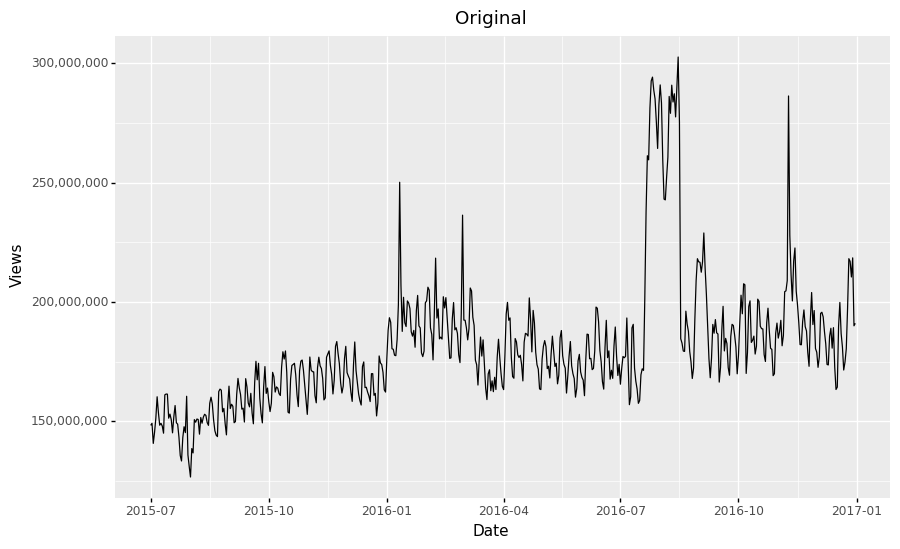

<ggplot: (8791480150498)>

In [10]:
day = pages.drop('Page', axis=1)
day = pd.DataFrame(day.sum()).reset_index()
day.columns = ['Date', 'Views']
day.head()
ggplot(day, aes('Date', 'Views')) + geom_line(aes(group = 1)) + scale_x_datetime(breaks=date_breaks('3 months'), labels=(date_format('%Y-%m'))) + scale_y_continuous(labels = comma_format()) + theme(figure_size=(10, 6)) + ggtitle('Original') 

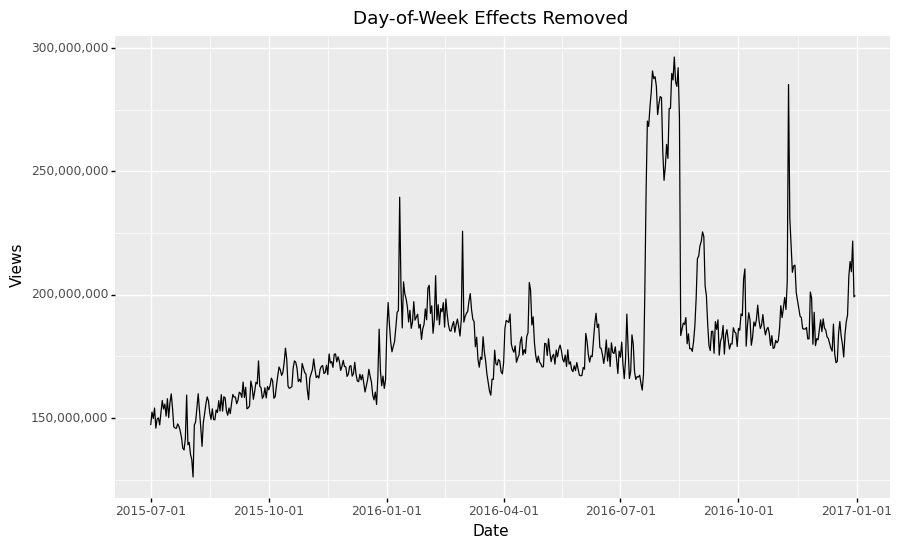

<ggplot: (8791498982931)>

In [11]:
day['weekday'] = [pd.to_datetime(date).strftime('%A') for date in day['Date']]
model = smf.ols('Views ~ C(weekday)', data=day).fit()
day['Views_rm'] = day['Views'].mean() + model.resid
ggplot(day, aes('Date', 'Views_rm')) + geom_line(aes(group = 1)) + scale_x_datetime(breaks=date_breaks('3 months')) + scale_y_continuous(labels = comma_format()) + ylab('Views') + theme(figure_size=(10, 6)) + ggtitle('Day-of-Week Effects Removed')

## Question 4: Repeat Q3 for the top 50K articles (30 points)

Repeat Q3 for the top 50K articles. For this you will need to first find the top 50K pages and limit your dataset to those. We define these top pages as those with the largest number of overall page views. Next you need to find the day of the week effect for this subset and plot the two time series.

In [12]:
top_pages = pages.copy(deep=True)
top_pages['sum'] = top_pages.loc[:, '2015-07-01':].sum(axis = 1)
top_pages = top_pages.sort_values('sum', ascending=False)[:50000]
top_pages.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,sum
38573,Main_Page_en.wikipedia.org_all-access_all-agents,20381245.0,20752194.0,19573967.0,20439645.0,20772109.0,22544669.0,21210887.0,19107911.0,19993848.0,...,22539246.0,25056620.0,25865746.0,28342885.0,26916991.0,27025053.0,26073819.0,24363967.0,26149541.0,1.206618e+10
9774,Main_Page_en.wikipedia.org_desktop_all-agents,11952559.0,12344021.0,11195848.0,11982470.0,12379684.0,14164829.0,12917172.0,11089923.0,12067334.0,...,16634676.0,18554711.0,18918826.0,21473188.0,20065005.0,19751910.0,19211634.0,17100925.0,19591761.0,8.774497e+09
74114,Main_Page_en.wikipedia.org_mobile-web_all-agents,8039732.0,8018607.0,7980511.0,8024814.0,7929962.0,7959839.0,7892357.0,7607871.0,7515302.0,...,3816041.0,3728439.0,4168094.0,4243273.0,4097335.0,4168668.0,4100929.0,4118692.0,3939419.0,3.153985e+09
139119,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,2983623.0,2965848.0,2900702.0,2687450.0,2827409.0,3062343.0,2999196.0,2995270.0,2995810.0,...,3520937.0,3188722.0,3643490.0,3903606.0,3907598.0,3732014.0,3577128.0,3514084.0,3286214.0,1.603934e+09
39180,Special:Search_en.wikipedia.org_all-access_all...,2034850.0,1984412.0,1763117.0,1620136.0,1766701.0,2108408.0,2118720.0,2052391.0,2300186.0,...,1734854.0,1473229.0,1421005.0,1769730.0,1902057.0,1816849.0,1895763.0,1811624.0,1576945.0,1.304079e+09


In [13]:
top_pages = top_pages.drop(['sum'], axis=1)

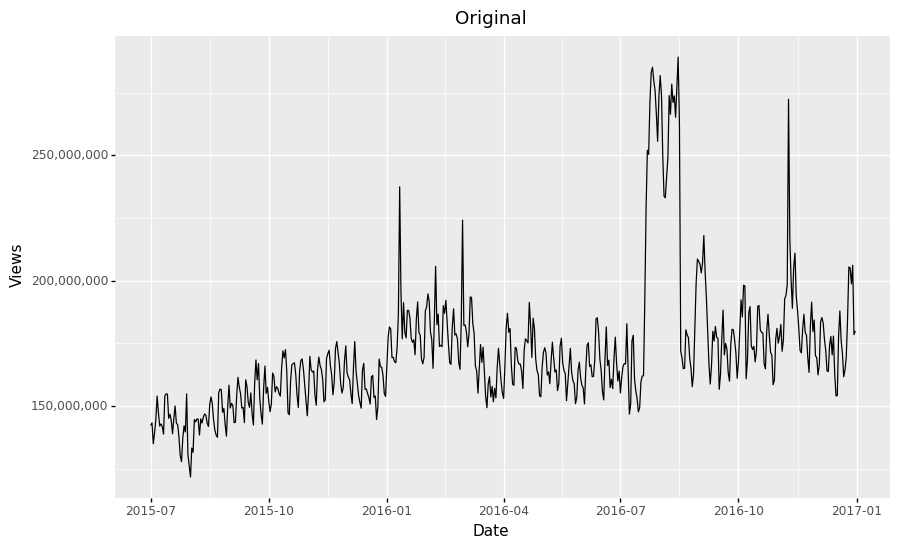

<ggplot: (8791445892518)>

In [14]:
day = top_pages.drop('Page', axis=1)
day = pd.DataFrame(day.sum()).reset_index()
day.columns = ['Date', 'Views']
day.head()
ggplot(day, aes('Date', 'Views')) + geom_line(aes(group = 1)) + scale_x_datetime(breaks=date_breaks('3 months'), labels=(date_format('%Y-%m'))) + scale_y_continuous(labels = comma_format()) + theme(figure_size=(10, 6)) + ggtitle('Original') 

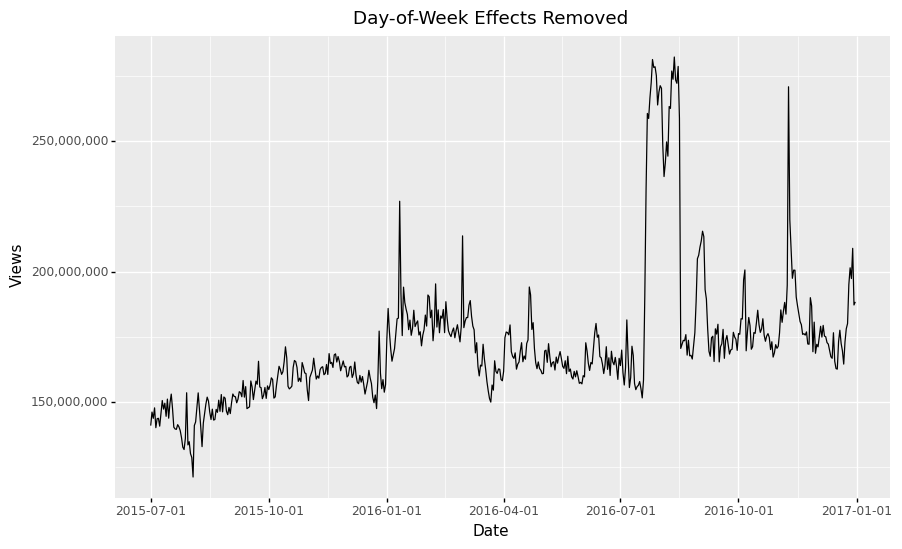

<ggplot: (8791506735809)>

In [15]:
day['weekday'] = [pd.to_datetime(date).strftime('%A') for date in day['Date']]
model = smf.ols('Views ~ C(weekday)', data=day).fit()
day['Views_rm'] = day['Views'].mean() + model.resid
ggplot(day, aes('Date', 'Views_rm')) + geom_line(aes(group = 1)) + scale_x_datetime(breaks=date_breaks('3 months')) + scale_y_continuous(labels = comma_format()) + ylab('Views') + theme(figure_size=(10, 6)) + ggtitle('Day-of-Week Effects Removed')

## What to submit

* The jupyter notebook file named 'uniquename_si618_hw9.ipynb'
* The HTML or PDF report generated by your notebook file that should similar to si618_hw9_solution.html